<a href="https://colab.research.google.com/github/Savara-k/Plant-Disease-Detection-Using-CNNs/blob/main/Plant_Disease_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Savara Khan**

FINAL PROJECT

Plant Disease Detection Using CNNs – Machine Learning Project                                                                          
- Supports: RGB, Grayscale, Edge-detected datasets
- Uses Kaggle PlantVillage dataset


# PlantVillage Dataset:

In [1]:
# === Download PlantVillage dataset ===
import kagglehub

dataset_path = kagglehub.dataset_download("emmarex/plantdisease")
print("Dataset downloaded to:", dataset_path)

# PlantVillage images are inside a folder named 'PlantVillage'
from pathlib import Path
root = Path(dataset_path)
img_dir = next((p for p in [root/"PlantVillage", root] if (p.exists() and any(p.iterdir()))), root/"PlantVillage")
print("Image root directory:", img_dir)

# === Collect image file paths and labels ===
img_exts = (".jpg", ".jpeg", ".png", ".JPG", ".JPEG", ".PNG")

files, labels = [], []
for cls_dir in sorted([p for p in img_dir.iterdir() if p.is_dir()]):
    cls = cls_dir.name
    imgs = [str(p) for p in cls_dir.rglob("*") if p.suffix in img_exts]
    files.extend(imgs)
    labels.extend([cls]*len(imgs))

import pandas as pd
df = pd.DataFrame({"file": files, "label": labels})

print(f"Total images: {len(df):,}")
print(f"Number of classes: {df['label'].nunique()}")
print("\nSample records:")
print(df.sample(5, random_state=42))

Using Colab cache for faster access to the 'plantdisease' dataset.
Dataset downloaded to: /kaggle/input/plantdisease
Image root directory: /kaggle/input/plantdisease/PlantVillage
Total images: 20,638
Number of classes: 15

Sample records:
                                                    file  \
12412  /kaggle/input/plantdisease/PlantVillage/Tomato...   
3024   /kaggle/input/plantdisease/PlantVillage/Potato...   
9547   /kaggle/input/plantdisease/PlantVillage/Tomato...   
16532  /kaggle/input/plantdisease/PlantVillage/Tomato...   
12591  /kaggle/input/plantdisease/PlantVillage/Tomato...   

                                             label  
12412  Tomato_Spider_mites_Two_spotted_spider_mite  
3024                         Potato___Early_blight  
9547                            Tomato_Late_blight  
16532        Tomato__Tomato_YellowLeaf__Curl_Virus  
12591  Tomato_Spider_mites_Two_spotted_spider_mite  


# CONFIGURATION:

In [2]:
# == CONFIGURATION ==

FEATURE_MODE = "rgb"          # "rgb" | "grayscale" | "edges"
IMG_SIZE = 128
BATCH_SIZE = 32
EPOCHS = 10

class_names = sorted(df["label"].unique())
num_classes = len(class_names)
print("\nClass names:", class_names)

label_to_index = {class_name: i for i, class_name in enumerate(class_names)}
df["label_idx"] = df["label"].map(label_to_index)

# Train/validation split
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df["label_idx"], random_state=42)


Class names: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']


# DATA PIPELINE:

In [3]:
# == DATA PIPELINE ==

import tensorflow as tf

def load_and_preprocess(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img = tf.cast(img, tf.float32) / 255.0
    return img, label

def to_grayscale(img, label):
    gray = tf.image.rgb_to_grayscale(img)
    return gray, label

def to_edges(img, label):
    gray = tf.image.rgb_to_grayscale(img)

    sobel = tf.image.sobel_edges(gray)  # shape: (H, W, 1, 2)
    gx = sobel[..., 0]
    gy = sobel[..., 1]
    mag = tf.sqrt(gx**2 + gy**2)

    # normalize
    mag_min = tf.reduce_min(mag)
    mag_max = tf.reduce_max(mag)
    mag = (mag - mag_min) / (mag_max - mag_min + 1e-8)

    return mag, label


# Build dataset
train_paths = train_df["file"].values
train_labels = train_df["label_idx"].values
val_paths = val_df["file"].values
val_labels = val_df["label_idx"].values

train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
val_ds = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))

train_ds = train_ds.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)

# Apply feature mode
if FEATURE_MODE == "rgb":
    input_channels = 3
elif FEATURE_MODE == "grayscale":
    train_ds = train_ds.map(to_grayscale, num_parallel_calls=tf.data.AUTOTUNE)
    val_ds = val_ds.map(to_grayscale, num_parallel_calls=tf.data.AUTOTUNE)
    input_channels = 1
elif FEATURE_MODE == "edges":
    train_ds = train_ds.map(to_edges, num_parallel_calls=tf.data.AUTOTUNE)
    val_ds = val_ds.map(to_edges, num_parallel_calls=tf.data.AUTOTUNE)
    input_channels = 1
else:
    raise ValueError("FEATURE_MODE must be rgb | grayscale | edges")

train_ds = train_ds.shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

print(f"\nUsing FEATURE_MODE = {FEATURE_MODE}, input channels = {input_channels}")



Using FEATURE_MODE = rgb, input channels = 3


# VISUALIZE SAMPLES:

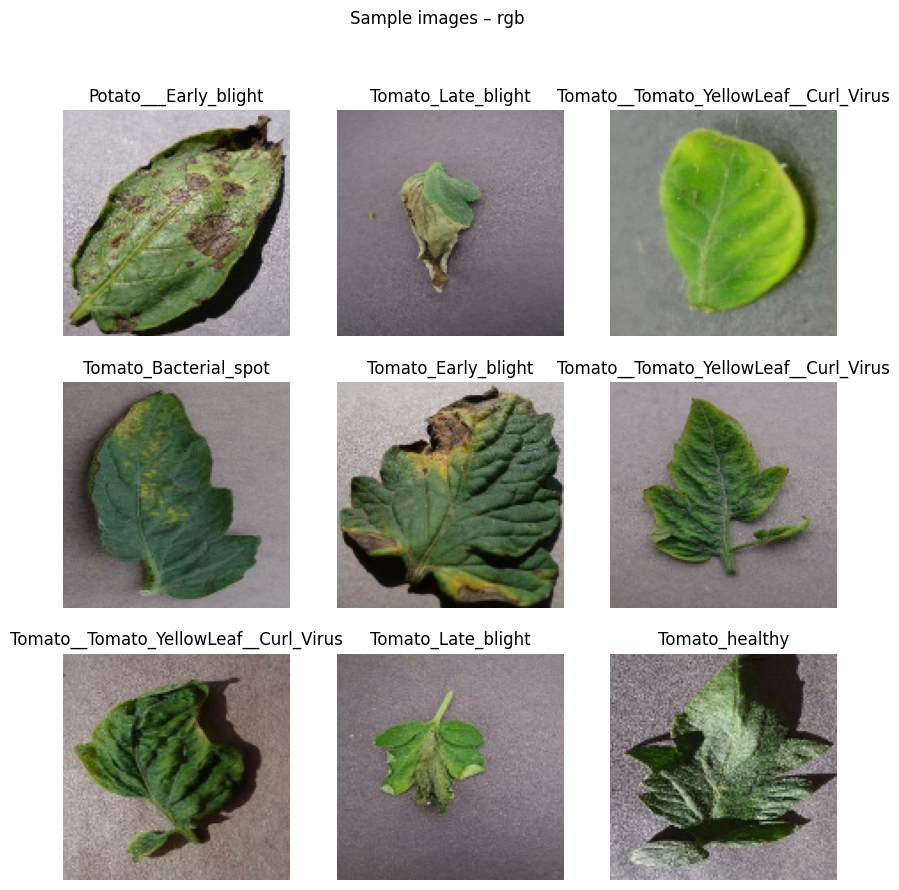

In [4]:
# == VISUALIZE SAMPLES==
import matplotlib.pyplot as plt

def show_sample_batch(dataset, mode_name, n=9):
    images, labels = next(iter(dataset))
    plt.figure(figsize=(10, 10))
    for i in range(n):
        ax = plt.subplot(3, 3, i + 1)
        img = images[i]
        if img.shape[-1] == 1:
            plt.imshow(tf.squeeze(img), cmap="gray")
        else:
            plt.imshow(img)
        plt.title(class_names[labels[i].numpy()])
        plt.axis("off")
    plt.suptitle(f"Sample images – {mode_name}")
    plt.show()

show_sample_batch(train_ds, FEATURE_MODE)



# BUILDING CNN MODEL:

In [5]:
# == BUILD CNN MODEL ==
from tensorflow.keras import layers, models

def build_cnn(img_size, channels, num_classes):
    model = models.Sequential([
        layers.Input(shape=(img_size, img_size, channels)),

        layers.Conv2D(32, 3, activation="relu", padding="same"),
        layers.MaxPooling2D(),

        layers.Conv2D(64, 3, activation="relu", padding="same"),
        layers.MaxPooling2D(),

        layers.Conv2D(128, 3, activation="relu", padding="same"),
        layers.MaxPooling2D(),

        layers.Flatten(),
        layers.Dense(256, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax")
    ])

    model.compile(
        optimizer="adam",
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

model = build_cnn(IMG_SIZE, input_channels, num_classes)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 15)             │         3,855 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,485,967 (32.37 MB)

 Trainable params: 8,485,967 (32.37 MB)

 Non-trainable params: 0 (0.00 B)

# TRAIN MODEL:

Epoch 1/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 70s 123ms/step - accuracy: 0.3746 - loss: 1.9693 - val_accuracy: 0.7914 - val_loss: 0.6809
Epoch 2/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 21s 37ms/step - accuracy: 0.7240 - loss: 0.8414 - val_accuracy: 0.8295 - val_loss: 0.5021
Epoch 3/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 41s 39ms/step - accuracy: 0.8060 - loss: 0.5749 - val_accuracy: 0.8665 - val_loss: 0.4163
Epoch 4/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 19s 35ms/step - accuracy: 0.8509 - loss: 0.4461 - val_accuracy: 0.8847 - val_loss: 0.3534
Epoch 5/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 20s 37ms/step - accuracy: 0.8789 - loss: 0.3664 - val_accuracy: 0.9021 - val_loss: 0.3220
Epoch 6/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 31s 58ms/step - accuracy: 0.8984 - loss: 0.2954 - val_accuracy: 0.8917 - val_loss: 0.3515
Epoch 7/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 21s 40ms/step - accuracy: 0.9165 - loss: 0.2488 - val_accuracy: 0.9135 - val_loss: 0.3062
Epoch 8/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 20s 37ms/step - accuracy: 0.9316 - loss: 0.1985 -

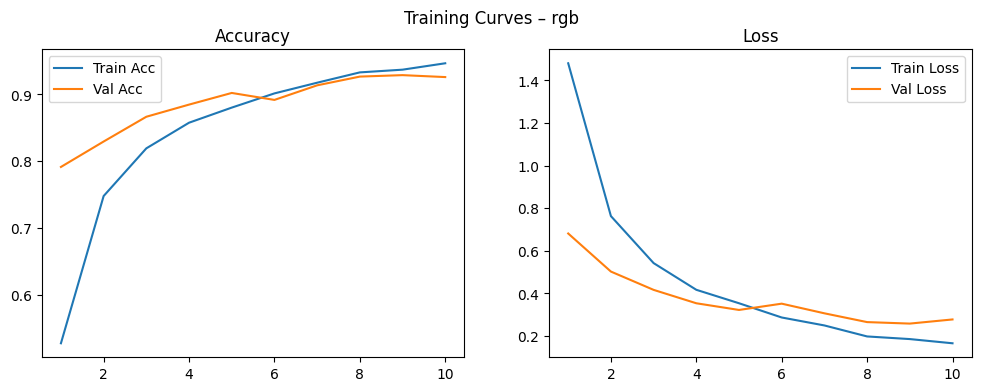

In [6]:
# == TRAIN MODEL ==
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)

# == TRAINING CURVES ==
def plot_history(hist, title):
    acc = hist.history["accuracy"]
    val_acc = hist.history["val_accuracy"]
    loss = hist.history["loss"]
    val_loss = hist.history["val_loss"]
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label="Train Acc")
    plt.plot(epochs, val_acc, label="Val Acc")
    plt.title("Accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label="Train Loss")
    plt.plot(epochs, val_loss, label="Val Loss")
    plt.title("Loss")
    plt.legend()

    plt.suptitle(title)
    plt.show()

plot_history(history, f"Training Curves – {FEATURE_MODE}")

# CONFUSION MATRIX:

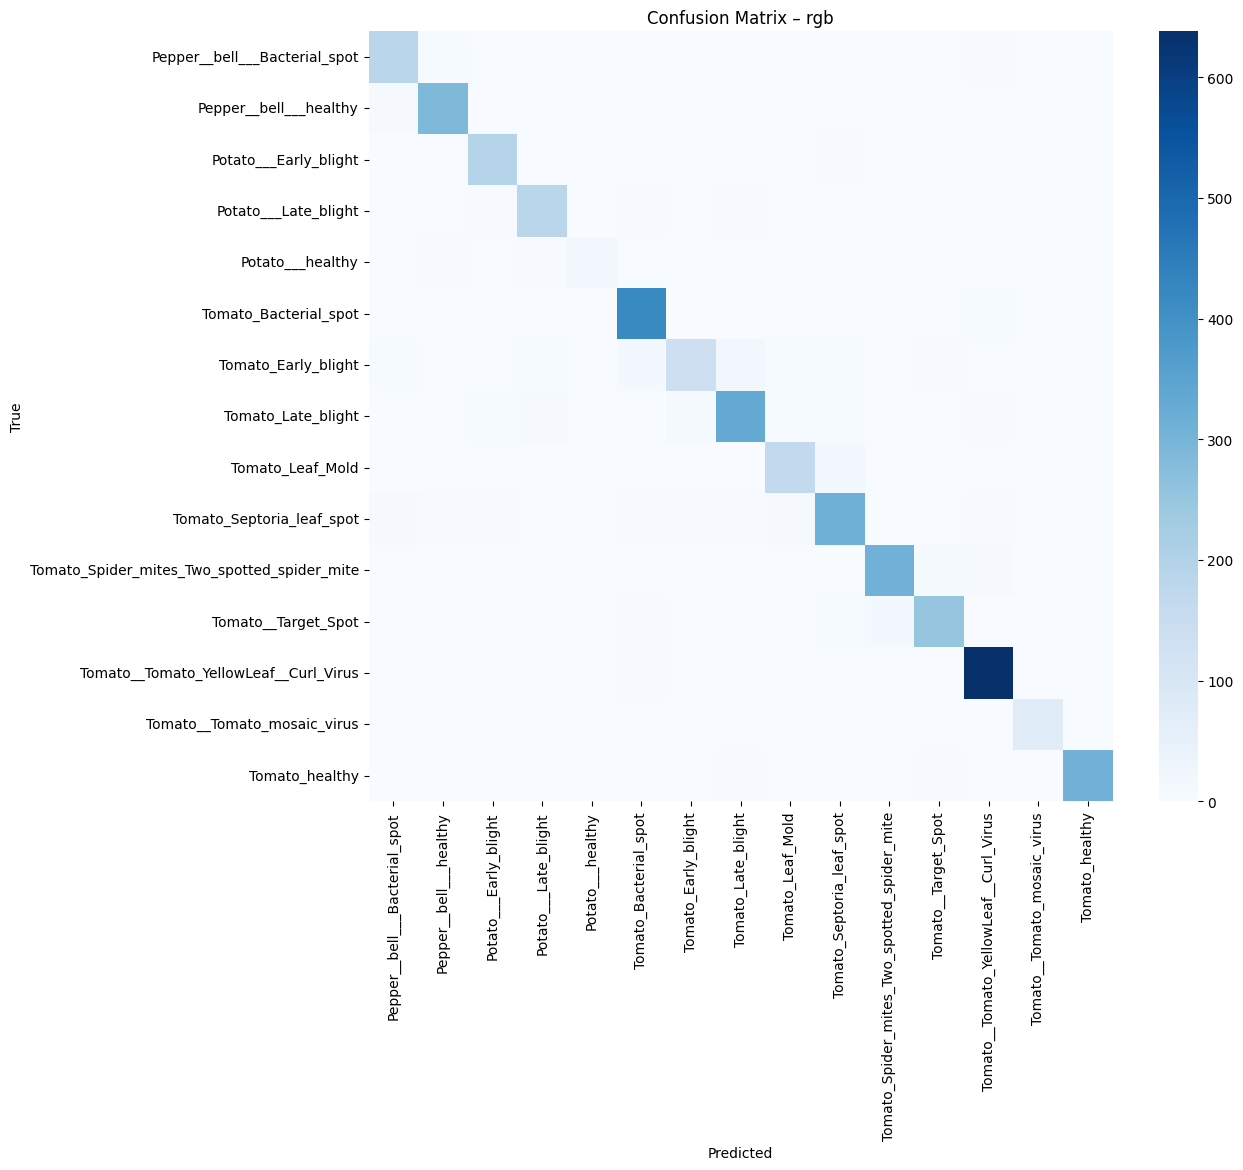


Classification Report:
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.88      0.91      0.89       199
                     Pepper__bell___healthy       0.95      0.97      0.96       296
                      Potato___Early_blight       0.93      0.96      0.94       200
                       Potato___Late_blight       0.89      0.93      0.91       200
                           Potato___healthy       1.00      0.70      0.82        30
                      Tomato_Bacterial_spot       0.93      0.98      0.95       426
                        Tomato_Early_blight       0.87      0.69      0.77       200
                         Tomato_Late_blight       0.90      0.87      0.89       382
                           Tomato_Leaf_Mold       0.88      0.88      0.88       190
                  Tomato_Septoria_leaf_spot       0.87      0.88      0.88       354
Tomato_Spider_mites_Two_spotted_spider_m

In [7]:
# == CONFUSION MATRIX ==
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import seaborn as sns

y_true = []
y_pred = []

for imgs, labs in val_ds:
    preds = model.predict(imgs, verbose=0)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(labs.numpy())

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, xticklabels=class_names, yticklabels=class_names,
            cmap="Blues", annot=False)
plt.title(f"Confusion Matrix – {FEATURE_MODE}")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


# PREDICTED VS ACTUAL GRID:

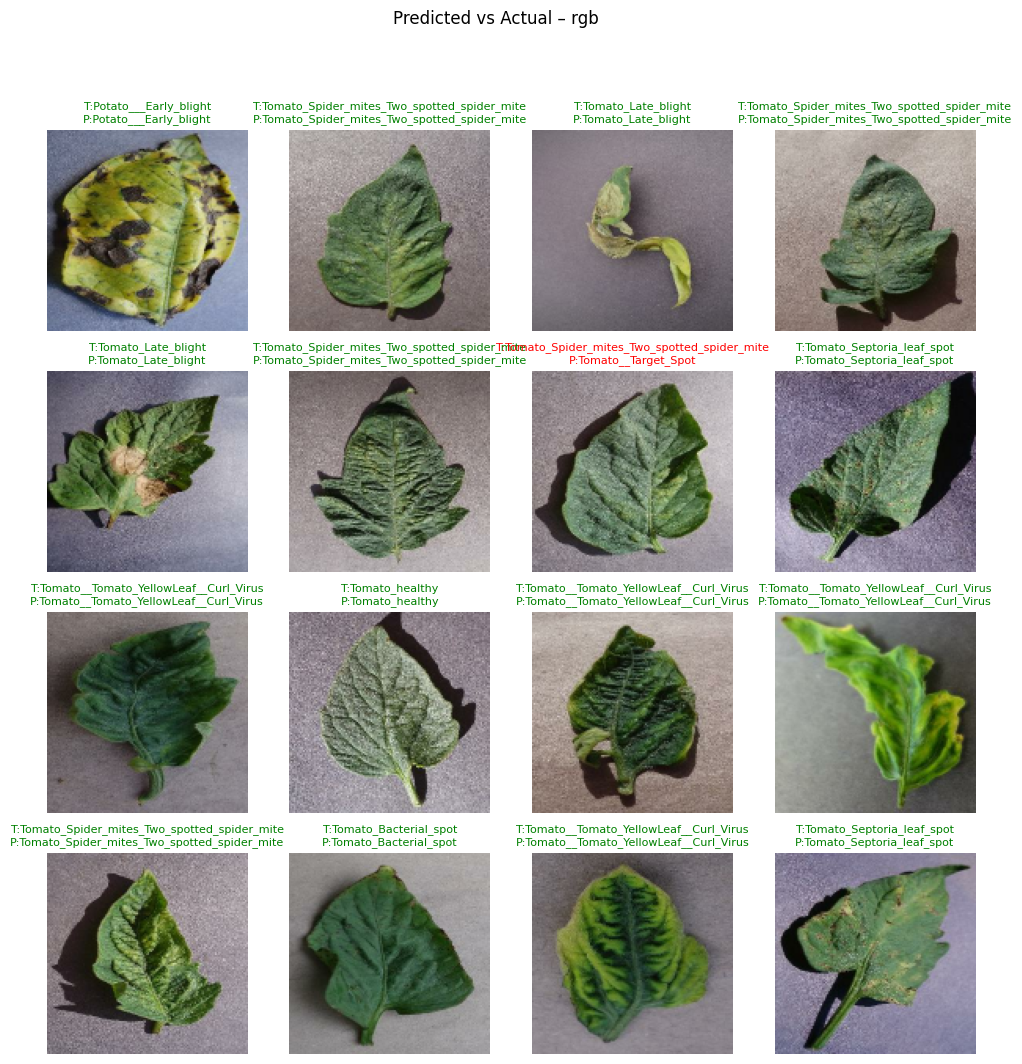

In [8]:
# == PREDICTED VS ACTUAL GRID ==


def show_predictions(dataset, model, mode_name, n=16):
    imgs, labs = next(iter(dataset))
    preds = model.predict(imgs, verbose=0)
    pred_lbls = np.argmax(preds, axis=1)

    plt.figure(figsize=(12, 12))
    for i in range(n):
        ax = plt.subplot(4, 4, i + 1)
        img = imgs[i]
        if img.shape[-1] == 1:
            plt.imshow(tf.squeeze(img), cmap="gray")
        else:
            plt.imshow(img)

        true = class_names[labs[i].numpy()]
        pred = class_names[pred_lbls[i]]
        color = "green" if true == pred else "red"
        plt.title(f"T:{true}\nP:{pred}", color=color, fontsize=8)
        plt.axis("off")

    plt.suptitle(f"Predicted vs Actual – {mode_name}")
    plt.show()

show_predictions(val_ds, model, FEATURE_MODE)